## Importación del CSV y las librerías correspondientes

In [84]:
import pandas as pd
import numpy as np

import skimpy as sk

import plotly.express as px
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
import pymannkendall as mk
from statsmodels.stats.diagnostic import het_white
from collections import namedtuple
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from xgboost import XGBRegressor 
import xgboost as xgb
from sktime.forecasting.compose import make_reduction
from sktime.split import SingleWindowSplitter
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.compose import (
    TransformedTargetForecaster)
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV, ExpandingWindowSplitter
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.performance_metrics.forecasting import make_forecasting_scorer

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

rcParams['figure.figsize'] = 15, 8

In [85]:
df = pd.read_csv("online_retail_sales.csv", encoding='utf8', sep=',')

### Declaración de funciones

In [86]:
# Análisis de la heterocedasticidad
def _check_convert_y(y):
    assert not np.any(np.isnan(y)) 
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y = y.values.squeeze()
    assert y.ndim==1
    return y
def check_heteroscedastisticity(y, confidence=0.05):
    y = _check_convert_y(y)
    res = namedtuple("White_Test", ["heteroscedastic", "lm_statistic", "lm_p_value"])
    x = np.arange(len(y))
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    lm_stat, lm_p_value, f_stat, f_p_value = het_white(results.resid, x)
    if lm_p_value<confidence and f_p_value < confidence:
        hetero = True
    else:
        hetero = False
    return res(hetero, lm_stat, lm_p_value)

# Análisis de la tendencia
def check_trend(time_series, alpha=0.05):
    result = mk.original_test(time_series, alpha=alpha)
    return result

# Test de Dickey Fuller
def adf_test(df, column_name):
    data_column = df[column_name]
    result = adfuller(data_column.dropna())
    print('p-value of the Dickey-Fuller test: %0.10f' % result[1])

# Gráficos de autocorrelación y correlación parcial
def plot_acf_pacf(df, column_name):
    data_column = df[column_name]
    pax_acf = plot_acf(df[column_name].dropna())
    pax_pacf = plot_pacf(df[column_name].dropna())              

## Comprensión del problema

| Variable de la Serie Temporal | Descripción |
| ---------------------------- | ----------- |
| Número de Factura            | Un número integral de 6 dígitos asignado de forma única a cada transacción. Si comienza con la letra 'C', indica una cancelación. |
| Código de Stock              | Un número integral de 5 dígitos asignado de forma única a cada producto distinto. |
| Descripción                  | Nombre del producto. |
| Cantidad                     | Las cantidades de cada producto (ítem) por transacción. |
| Fecha de Factura             | El día y la hora en que se generó cada transacción. |
| Precio Unitario              | Precio del producto por unidad en libras esterlinas. |
| ID de Cliente                | Un número integral de 5 dígitos asignado de forma única a cada cliente. |
| País                         | El nombre del país donde reside cada cliente. |

## Exploración y entendimiento de los datos

In [87]:
# Observamos las 10 primeras filas
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2022-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2022-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2022-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2022-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2022-12-01 08:34:00,1.69,13047.0,United Kingdom


In [88]:
# Observamos el tipo de datos de nuestro df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [89]:
# Cambiamos el tipo de la columna 'InvoiceDate' de 'object' a 'datetime'
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [90]:
# Obtenemos un análisis descriptivo 
sk.skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 541909 │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 8      │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 1     │                                                          │
│                                │ datetime64  │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name   ┃ NA       ┃ NA %   ┃ mean   ┃ sd    ┃ p0       ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ Quantity      │        0 │      0 │    9.6 │   220 │   -81000 │      1 │      3 │     10 │  81000 │     ▇  │  │
│ │ UnitPrice     │        0 │      0 │    4.6 │    97 │   -11000 │    1.2 │    2.1 │    4.1 │  39000 │    ▇   │  │
│ │ CustomerID    │   135080 │  24.93 │  15000 │  1700 │    12000 │  14000 │  15000 │  17000 │  18000 │ ▇▆▇▆▆▇ │  │
│ └───────────────┴──────────┴────────┴────────┴───────┴──────────┴────────┴────────┴────────┴────────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA   ┃ NA %    ┃ first                      ┃ last                       ┃ frequency    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩  │
│ │ InvoiceDate      │    0 │       0 │    2022-12-01 08:26:00     │    2023-12-09 12:50:00     │ None         │  │
│ └──────────────────┴──────┴─────────┴────────────────────────────┴────────────────────────────┴──────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA         ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ InvoiceNo                │          0 │          0 │                           1 │                  541909 │  │
│ │ StockCode                │          0 │          0 │                           1 │                  541946 │  │
│ │ Description              │       1454 │       0.27 │                         4.6 │                 2506861 │  │
│ │ Country                  │          0 │          0 │                         1.9 │                 1038670 │  │
│ └──────────────────────────┴────────────┴────────────┴─────────────────────────────┴─────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [91]:
# Observamos valores descriptivos con otra función
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2023-07-04 13:34:57.156387072,4.611114,15287.690570
min,-80995.000000,2022-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2023-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2023-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2023-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2023-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [92]:
# Vemos los nulos que  hay en el df, decidimos no manipularlos ya que no van a afectar a la serie temporal en sí
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Observamos las columnas con nulos. Decidimos no eliminarlos, ni imputarlos, ya que no son datos relevantes para nuestra variable a predecir.

In [93]:
df['Description'].value_counts()

Description
WHITE HANGING HEART T-LIGHT HOLDER     2369
REGENCY CAKESTAND 3 TIER               2200
JUMBO BAG RED RETROSPOT                2159
PARTY BUNTING                          1727
LUNCH BAG RED RETROSPOT                1638
                                       ... 
Missing                                   1
historic computer difference?....se       1
DUSTY PINK CHRISTMAS TREE 30CM            1
WRAP BLUE RUSSIAN FOLKART                 1
PINK BERTIE MOBILE PHONE CHARM            1
Name: count, Length: 4223, dtype: int64

In [94]:
df['CustomerID'].value_counts()

CustomerID
17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
           ... 
15070.0       1
15753.0       1
17065.0       1
16881.0       1
16995.0       1
Name: count, Length: 4372, dtype: int64

In [95]:
# Observamos los valores de la variable a predecir y vemos que hay negativos
df['Quantity'].value_counts()

Quantity
 1        148227
 2         81829
 12        61063
 6         40868
 4         38484
           ...  
-472           1
-161           1
-1206          1
-272           1
-80995         1
Name: count, Length: 722, dtype: int64

In [96]:
# Observamos el porcentaje de países en el df, viendo que la mayoría de transacciones se producen en UK
df['Country'].value_counts(normalize=True)

Country
United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
Eu

## Limpieza de datos

In [97]:
# Creamos una copia del df original para no manipularlo
df_profit = df.copy()

In [98]:
# Observamos si hay duplicados
df_profit.duplicated().sum()

5268

In [99]:
# Eliminamos duplicados
df_profit = df_profit.drop_duplicates()

In [100]:
# Comprobamos que los hemos eliminado
assert df_profit.duplicated().sum() == 0, "Hay duplicados en df_profit"

In [101]:
# Filtramos las filas en 'InvoiceNo' que comienzan con 'C'
# Vemos que se relacionan con cantidades negativas
canceled_invoice = df_profit[df_profit['InvoiceNo'].str.startswith('C')]
canceled_invoice.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2022-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2022-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2022-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2022-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2022-12-01 10:24:00,0.29,17548.0,United Kingdom


In [102]:
# Eliminamos las transacciones canceladas del df_profit que no nos interesan
df_profit = df_profit[~df_profit['InvoiceNo'].str.startswith('C')]

In [103]:
# Observamos si por casualidad hubiera en la columna de cantidad de ventas el valor de '0' y concluímos que no hay
df_profit_zero_sales = df_profit[df_profit['Quantity'] == 0]
df_profit_zero_sales

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [104]:
# Creamos nuevas columnas para la fecha y la hora por si en algún momento lo queremos utilizar
df_profit['Date'] = df_profit['InvoiceDate'].dt.date
df_profit['Hour'] = df_profit['InvoiceDate'].dt.time
df_profit.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,2022-12-01,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,2022-12-01,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,2022-12-01,08:26:00


In [105]:
# Observamos de nuevo el df para ver el tipo de dato de las columnas creadas
df_profit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 527390 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    527390 non-null  object        
 1   StockCode    527390 non-null  object        
 2   Description  525936 non-null  object        
 3   Quantity     527390 non-null  int64         
 4   InvoiceDate  527390 non-null  datetime64[ns]
 5   UnitPrice    527390 non-null  float64       
 6   CustomerID   392732 non-null  float64       
 7   Country      527390 non-null  object        
 8   Date         527390 non-null  object        
 9   Hour         527390 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 44.3+ MB


In [106]:
# Como únicamente me voy a quedar la columna de 'Date', le cambiamos el tipo de dato
df_profit['Date'] = pd.to_datetime(df_profit['Date'], format = '%Y/%m/%d')

In [107]:
# Creamos un df con la fecha y el beneficio por fecha
df_profit['Profit'] = df_profit['Quantity'] * df_profit['UnitPrice']
df_profit = df_profit.groupby('Date')['Profit'].sum().reset_index()
# Ordenamos las fechas
df_profit = df_profit.sort_values(by='Date')
# Cambiamos el índice
df_profit = df_profit.set_index('Date')
df_profit

,Profit
Date,
2022-12-01,58776.79
2022-12-02,47629.42
2022-12-03,46898.63
2022-12-05,31364.63
2022-12-06,54624.15
...,...
2023-12-05,88620.84
2023-12-06,56558.83
2023-12-07,75315.55


In [108]:
# Definimos la frecuencia del índice
df_profit = df_profit.asfreq('D')

In [109]:
# Visualizamos un gráfico de líneas con el beneficio por día
px.line(df_profit)

In [110]:
# Observamos que hay valores 'missing' que caen en domingos y festivos según el gráfico de arriba
df_profit.isnull().sum()

Profit    69
dtype: int64

In [111]:
# Hacemos una copia de df_profit con el objetivo de poder manipular los datos en futuros preprocesamientos
df_baseline = df_profit.copy()

In [112]:
# Imputamos los valores nulos por '0', con la lógica de que esos días se obtiene 0 beneficio
df_baseline['Profit'] = df_baseline['Profit'].fillna(0)
# Comprobamos que no hay nulos en el df_baseline
assert df_baseline.isnull().sum().all() == 0, "Hay valores nulos en el df_baseline"

¿Qué días son los que presentan mayor beneficio? ¿Cuál es la distribución de beneficio por mes? ¿Hay valores atípicos?
Estas cuestiones nos ayudan a informar los argumentos que hay que poner en los transformadores.

In [113]:
# A continuación vamos a analizar los días que suponen mayor beneficio
df_baseline['day_week'] = df_baseline.index.day_name()

days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_baseline['day_week'] = pd.Categorical(df_baseline['day_week'], categories=days_order, ordered=True)

# Calculamos la suma de la columna 'Profit' para cada día de la semana
grouped_data = df_baseline.groupby('day_week')['Profit'].sum().sort_index()
# Creamos un gráfico de barras para observar los días con mayor beneficio
px.bar(x=grouped_data.index, y=grouped_data.values, labels={'x': 'day_week', 'y': 'Profit'})



Vemos que los mejores días corresponden con el miércoles y viernes, y que los domingos no se producen ventas.

In [114]:
# Observamos las distintas distribuciones por mes
df_baseline['month'] = df_baseline.index.month_name()

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October','November','December']
df_baseline['month'] = pd.Categorical(df_baseline['month'], categories=month_order, ordered=True)

grouped_data = df_baseline.groupby('month')['Profit'].sum().sort_index()
# Visualizamos boxplots para observar también los atípicos
px.box(df_baseline, x='month', y='Profit', labels={'month': 'Mes', 'Profit': 'Beneficio'})

Vemos que los meses de enero, agosto y septiembre son los que presencian mayor número de atípicos.

## Decomposición de series temporales

### Modelo aditivo

In [115]:
# Descomponemos la serie temporal para visualizarla utilizando el modelo 'aditivo'
result_add = seasonal_decompose(df_baseline['Profit'], model = 'additive', period = 7)

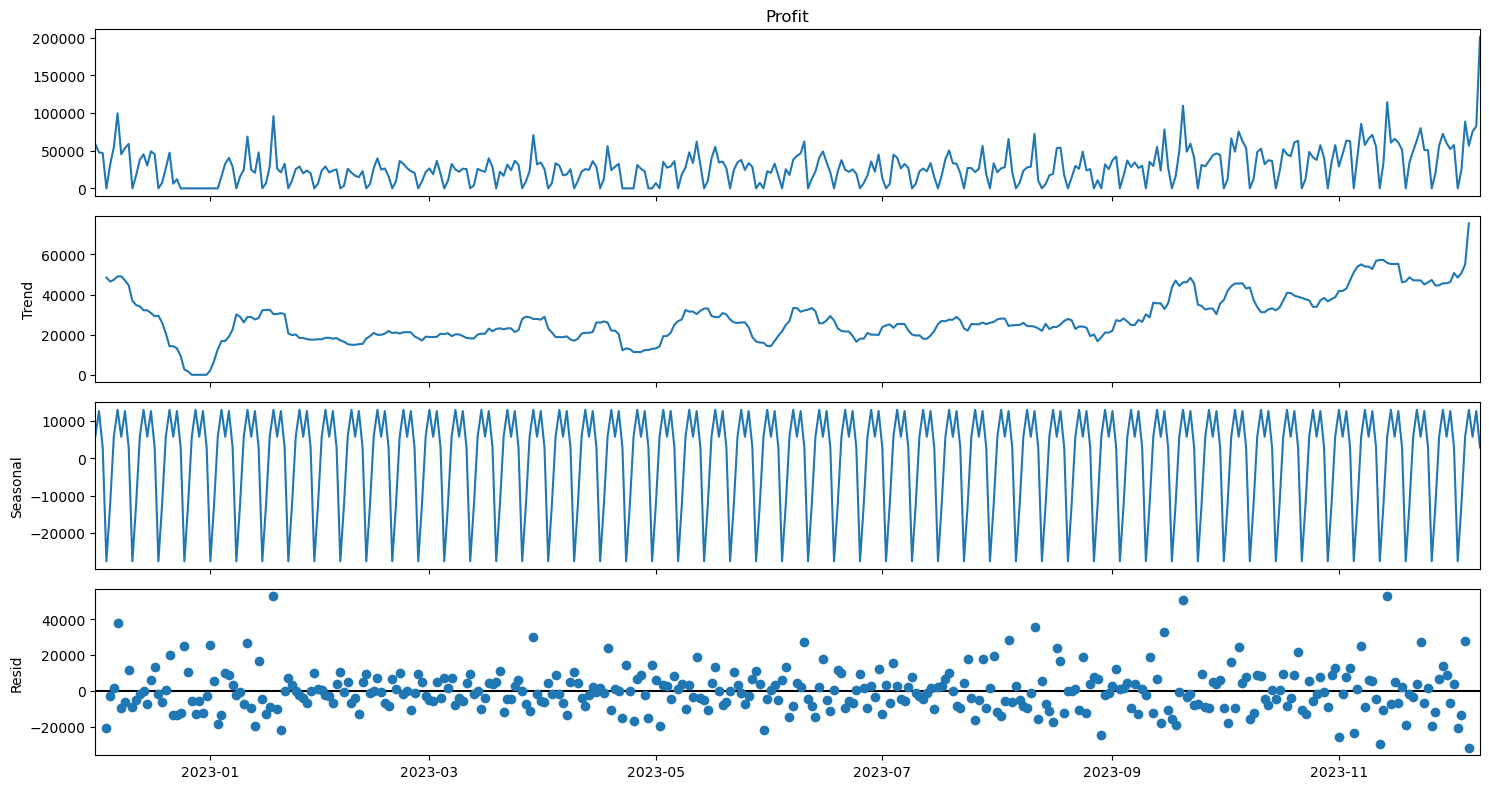

In [116]:
# Visualizamos la serie, tendencia, estacionalidad y ruido
result_add.plot()
plt.show()

Observamos cierta estacionalidad y tendencia.

## Autocorrelación y autocorrelación parcial

In [117]:
# Calculamos el índice de Pearson de la información presente con respecto al pasado
df_baseline_corr = df_baseline['Profit'].autocorr()  
df_baseline_corr

0.42200818543950386

Observamos que no hay una autocorrelación muy fuerte con respecto al pasado.

Obtenemos los gráficos de autocorrelación y autocorrelación parcial basándonos en los datos de un mes para poder detectar algún patrón.

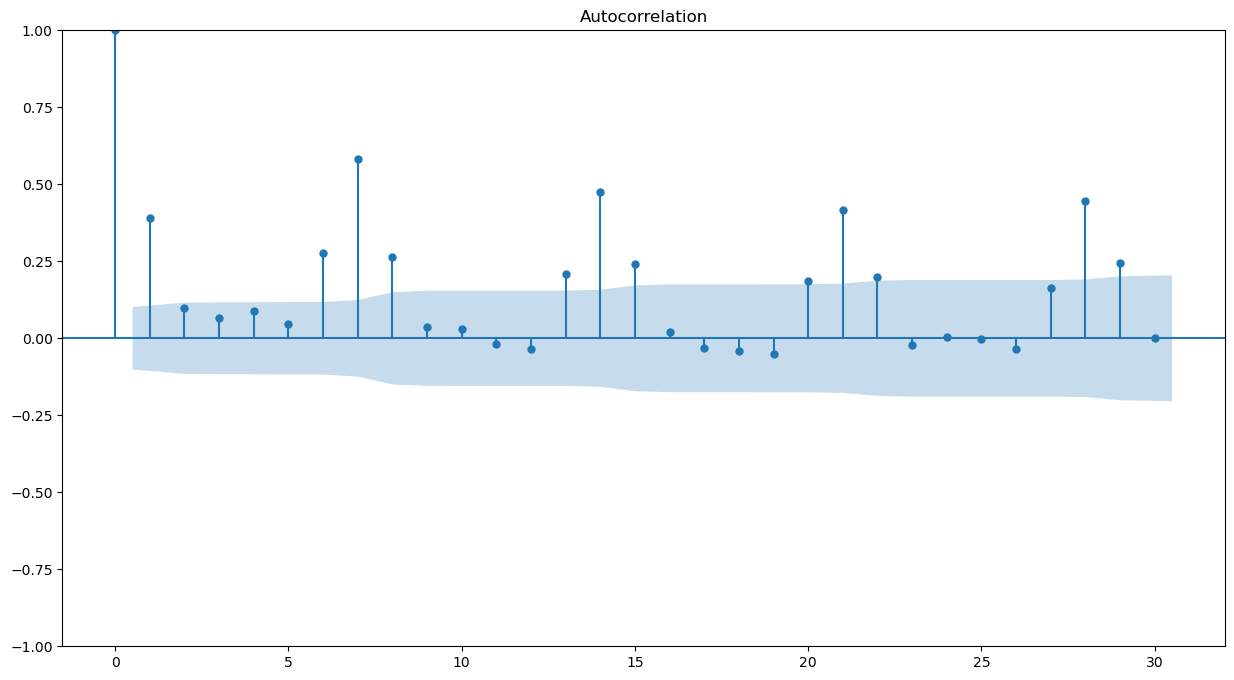

In [118]:
plot_acf(df_baseline['Profit'], lags = 30) 
plt.show()

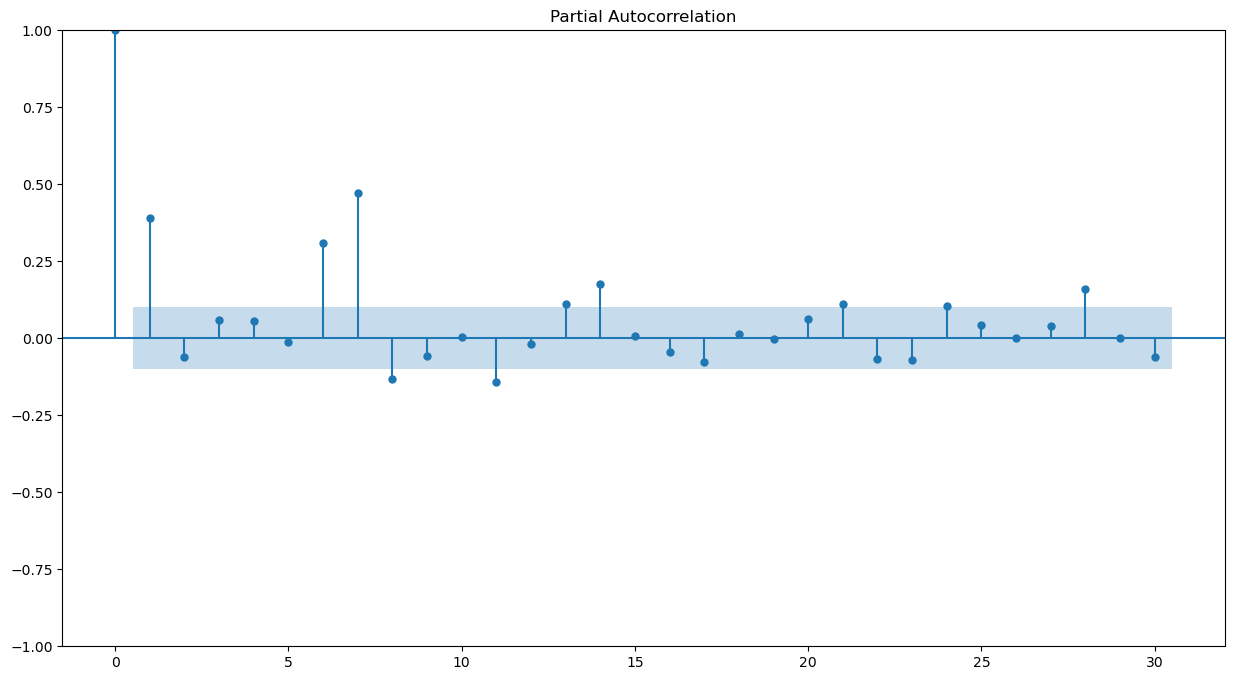

In [119]:
plot_pacf(df_baseline['Profit'], lags = 30)
plt.show()

Observamos que puede tener cierta influencia en las ventas los días del fin de semana.

## Análisis de estacionariedad y heterocedasticidad de la serie

Aplicamos el test de Dickey Fuller para comprobar si la serie es estacionaria y así facilitar el análisis y aplicación de modelos.

In [120]:
adf_test(df_baseline, 'Profit')

p-value of the Dickey-Fuller test: 0.8628424928


Como el p-value es mayor de 0.05, no rechazamos la hipótesis nula, ya que la serie no es estacionaria.

Para corregir la no estacionariedad, necesitamos diferenciar el valor de nuestra serie de tiempo: restar la observación anterior de la observación actual.

In [121]:
df_baseline['diff_profit'] = df_baseline['Profit'] - df_baseline['Profit'].shift(1)
df_baseline.head()

,Profit,day_week,month,diff_profit
Date,,,,
2022-12-01,58776.79,Thursday,December,NaN
2022-12-02,47629.42,Friday,December,-11147.37
2022-12-03,46898.63,Saturday,December,-730.79
2022-12-04,0.00,Sunday,December,-46898.63
2022-12-05,31364.63,Monday,December,31364.63


In [122]:
# Visualizamos si hemos quitado la estacionalidad aplicando la primera diferencia
px.line(df_baseline['diff_profit'])

In [123]:
# Pasamos de nuevo el test de Dickey Fuller sobre la diferencia
adf_test(df_baseline, 'diff_profit')

p-value of the Dickey-Fuller test: 0.0000000234


Como se puede ver, podemos rechazar la hipótesis nula porque tenemos un p value < 0.05. Esto sugiere que la serie ya es estacionaria.

El modelo ARIMA tiene una **parte estacional** y otra **general** que hay que tener en cuenta. Hasta aquí hemos tratado la general, ahora vamos a analizar la estacional, para poder entrenarlo sin problemas a posteriori.

In [124]:
# Aquí a cada observación le restamos el valor de hace 7 días, en vez del anterior, y lo haces sobre la columna general, no sobre las diferencias
# Lo hacemos sobre 7 días ya que nos interesa la estacionalidad semanal
df_baseline['seas_diff'] = df_baseline['Profit'] - df_baseline['Profit'].shift(7)
df_baseline

,Profit,day_week,month,diff_profit,seas_diff
Date,,,,,
2022-12-01,58776.79,Thursday,December,NaN,NaN
2022-12-02,47629.42,Friday,December,-11147.37,NaN
2022-12-03,46898.63,Saturday,December,-730.79,NaN
2022-12-04,0.00,Sunday,December,-46898.63,NaN
2022-12-05,31364.63,Monday,December,31364.63,NaN
...,...,...,...,...,...
2023-12-05,88620.84,Tuesday,December,64143.37,31655.11
2023-12-06,56558.83,Wednesday,December,-32062.01,-15825.99
2023-12-07,75315.55,Thursday,December,18756.72,15289.98


In [125]:
# Visualizamos la estacionalidad
px.line(df_baseline['seas_diff'])

In [126]:
# Hacemos el test de Dickey Fuller sobre la diferencia estacional
adf_test(df_baseline, 'seas_diff')

p-value of the Dickey-Fuller test: 0.0000071757


El p-value es inferior a 0.05, por lo que podemos rechazar la hipótesis nula de no estacionariedad. Eso sugiere usar 0 para el valor D (por ejemplo, la diferencia estacional)

In [127]:
# Aplicamos ahora el test de Mann-Kendall sobre la tendencia
check_trend(df_baseline['Profit'].dropna(), alpha=0.05)

Mann_Kendall_Test(trend='increasing', h=True, p=8.971645648614412e-11, z=6.483335966886624, Tau=0.22383908474430475, s=15613.0, var_s=5798558.333333333, slope=66.86977011494255, intercept=13425.177873563212)

Rechazamos también la hipótesis nula sobre la tendencia.

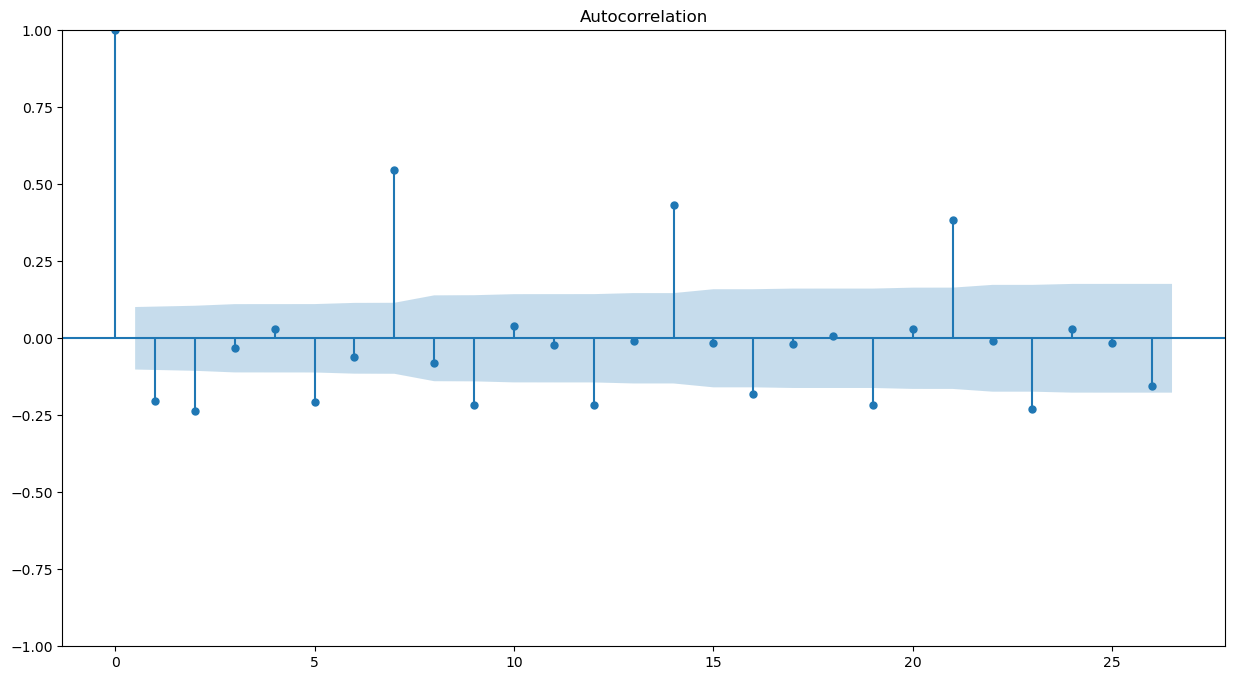

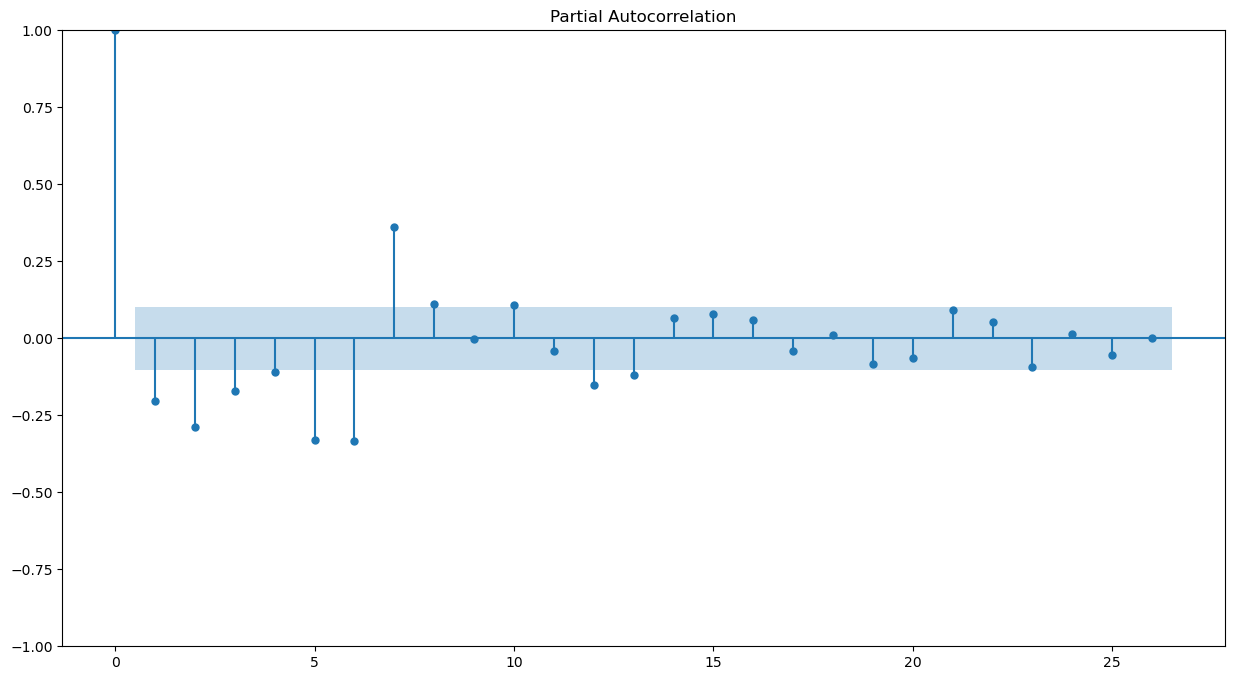

In [128]:
# Queremos ver ahora cómo se comporta la variable con la primera diferenciación aplicada y ver qué retardos meter al modelo
plot_acf_pacf(df_baseline, 'diff_profit')

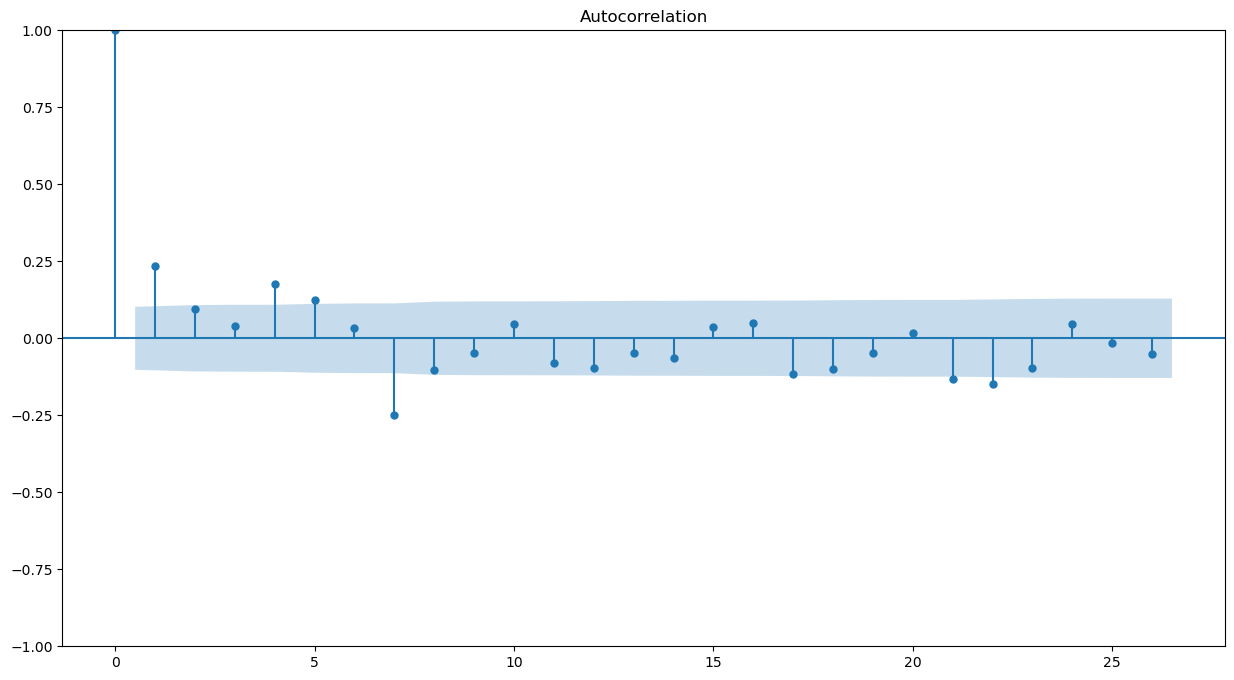

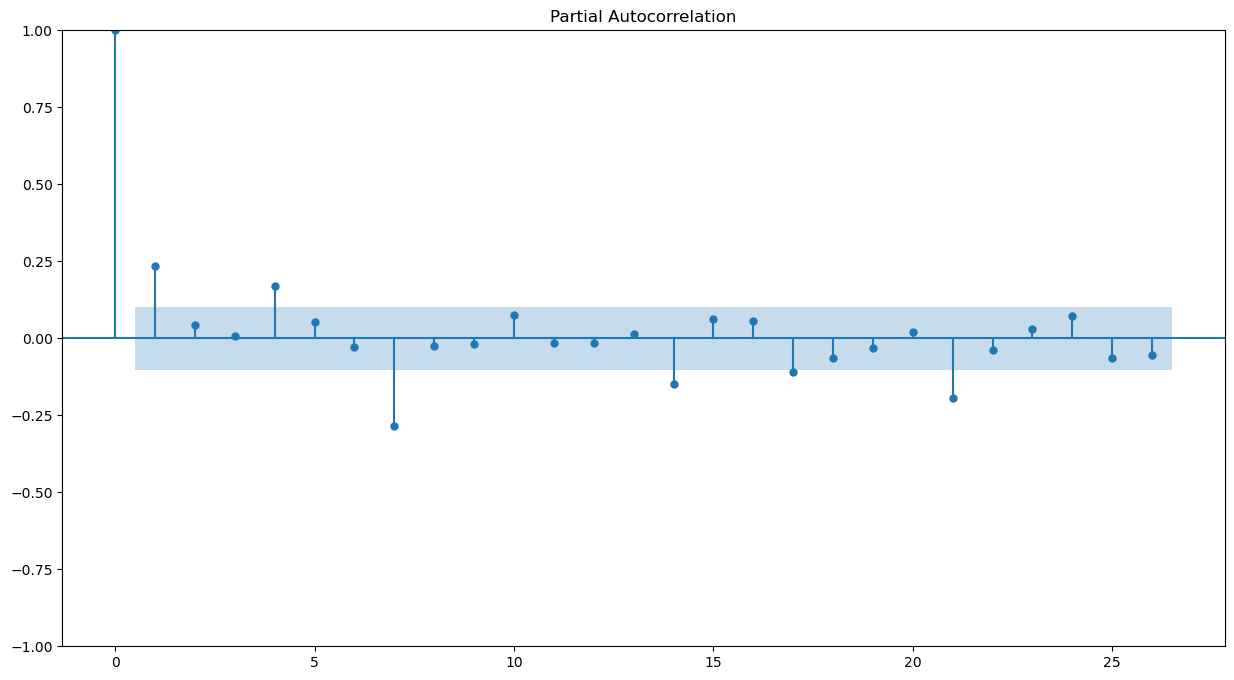

In [129]:
# Ahora hacemos un análisis general con el componente estacional
plot_acf_pacf(df_baseline, 'seas_diff')

Parece que podría haber cierta estacionalidad semanal.

In [130]:
# Analizamos la heterocedasticidad
check_heteroscedastisticity(df_baseline['Profit'].dropna(), confidence = 0.05) 

White_Test(heteroscedastic=True, lm_statistic=24.305051372358893, lm_p_value=5.275032665130866e-06)

## Preprocesamiento 1

### Modelo Arima

In [131]:
# Partición en train y test
y_train, y_test = temporal_train_test_split(df_baseline['Profit'], test_size=60)
display(y_train.shape, y_train.head(2), y_train.tail(2))
display(y_test.shape, y_test.head(2), y_test.tail(2))

(314,)

Date
2022-12-01    58776.79
2022-12-02    47629.42
Freq: D, Name: Profit, dtype: float64

Date
2023-10-09    12273.10
2023-10-10    48121.66
Freq: D, Name: Profit, dtype: float64

(60,)

Date
2023-10-11    52537.31
2023-10-12    32083.11
Freq: D, Name: Profit, dtype: float64

Date
2023-12-08     82371.55
2023-12-09    200900.98
Freq: D, Name: Profit, dtype: float64

Los valores que vamos a elegir pueden no ser óptimos y es posible que debamos probar diferentes para ajustar el modelo.

In [132]:
# Instanciamos el modelo
model_profit = SARIMAX(y_train,order=(1,1,1), seasonal_order=(1, 0, 0, 7)) 
# Entrenamos el modelo
result_profit = model_profit.fit()
# Obtenemos resultados
result_profit.summary()

c:\Users\alici\anaconda3\envs\Nuclio\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             Profit   No. Observations:                  314
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 7)   Log Likelihood               -3456.832
Date:                            Sun, 04 Feb 2024   AIC                           6921.665
Time:                                    15:54:25   BIC                           6936.650
Sample:                                12-01-2022   HQIC                          6927.653
                                     - 10-10-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2840      0.049      5.757      0.000       0.187       0.381
ma.L1         -1.0000      0.054    -18.555      0.000      -1.106      -0.894
ar.S.L7        0.5474      0.034     16.012      0.000       0.480       0.614
sigma2      2.254e+08   2.39e-10   9.41e+17      0.000    2.25e+08    2.25e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               199.04
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             1.10
Prob(H) (two-sided):                  0.75   Kurtosis:                         6.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.03e+32. Standard errors may be unstable.
"""

### Diagnóstico

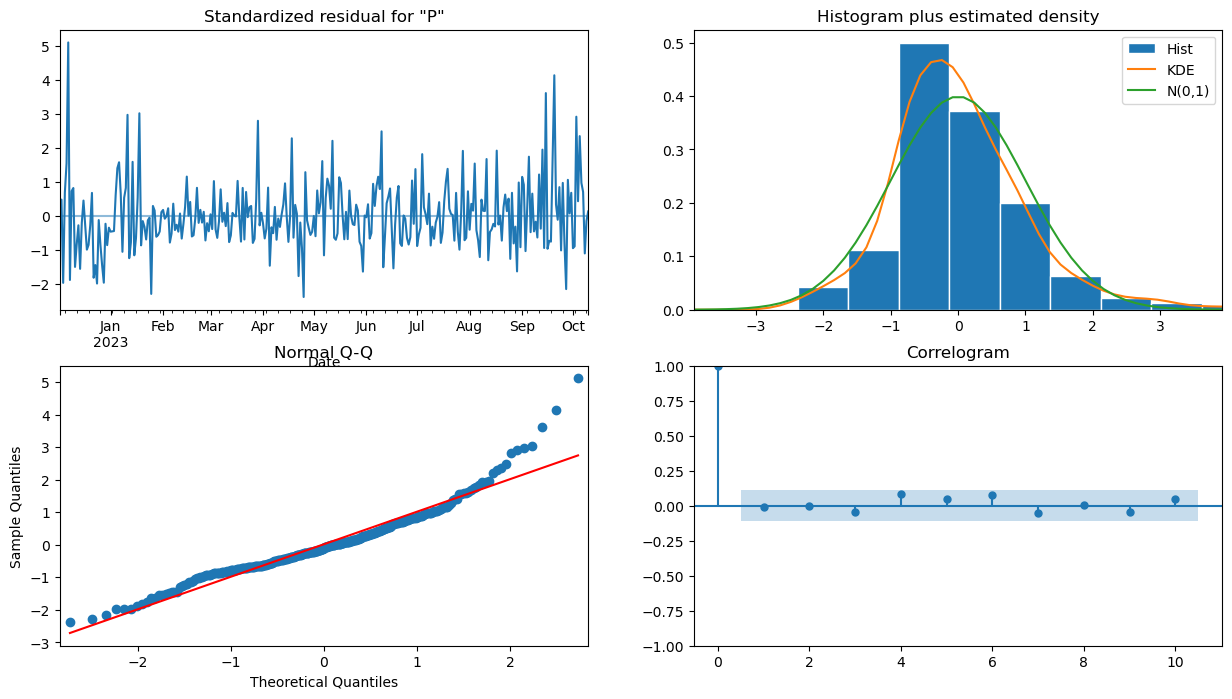

In [133]:
# Obtenemos un gráfico de los resultados del modelo ARIMA
result_profit.plot_diagnostics()
plt.show()

### Autoarima

Aplicamos autoarima con rangos especificados para que nos devuelva el modelo más óptimo.

In [134]:
auto_arima_pax = auto_arima(y_train, 
                       start_q=1,
                       max_p=7,
                       max_q=7,
                       m=7,
                       seasonal=True,
                       D=0,
                       max_d = 3,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
auto_arima_pax.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=6940.251, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=7144.699, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=7032.219, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=7005.877, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=7142.701, Time=0.02 sec
 ARIMA(2,1,1)(0,0,1)[7] intercept   : AIC=6984.150, Time=0.28 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(2,1,1)(2,0,1)[7] intercept   : AIC=6940.002, Time=3.15 sec
 ARIMA(2,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=2.44 sec
 ARIMA(2,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=3.55 sec
 ARIMA(2,1,1)(1,0,2)[7] intercept   : AIC=6939.053, Time=3.29 sec
 ARIMA(2,1,1)(0,0,2)[7] intercept   : AIC=6967.455, Time=1.09 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=6938.781, Time=2.92 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=6938.833, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  314
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -3462.471
Date:                                Sun, 04 Feb 2024   AIC                           6936.943
Time:                                        15:55:29   BIC                           6959.420
Sample:                                    12-01-2022   HQIC                          6945.925
                                         - 10-10-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2479      0.112      2.217      0.027       0.029       0.467
ma.L1         -0.9599      0.035    -27.703      0.000      -1.028      -0.892
ar.S.L7        0.9915      0.023     43.385      0.000       0.947       1.036
ma.S.L7       -0.7587      0.124     -6.106      0.000      -1.002      -0.515
ma.S.L14      -0.1560      0.109     -1.431      0.152      -0.370       0.058
sigma2      3.905e+08   1.25e-10   3.12e+18      0.000     3.9e+08     3.9e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               292.16
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             1.20
Prob(H) (two-sided):                  0.91   Kurtosis:                         7.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.06e+33. Standard errors may be unstable.
"""

In [135]:
# Ajuste del modelo
model_auto = SARIMAX(y_train,order=(1, 1, 1),
              seasonal_order=(1, 0, 2, 7),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_auto_arima = model_auto.fit()

In [136]:
# Predecimos
forecast_auto_arima = results_auto_arima.predict(start = len(y_train),
                           end=len(y_train)+59,
                           typ='levels').rename('forecast_auto_arima')

c:\Users\alici\anaconda3\envs\Nuclio\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



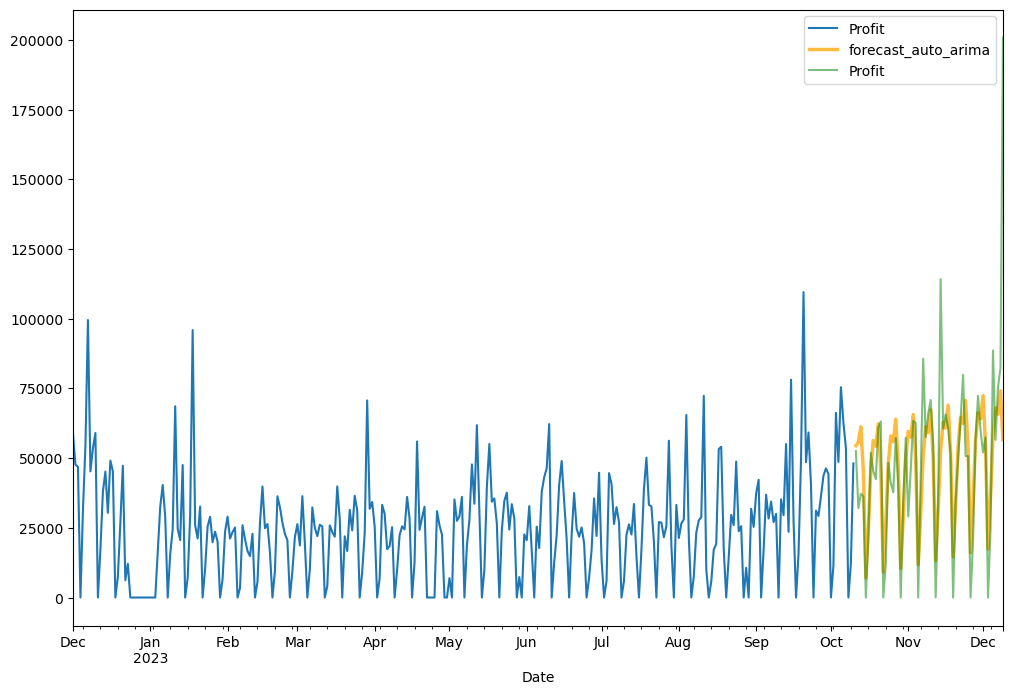

In [137]:
# Pintamos las predicciones
y_train.plot(figsize=(12,8),legend=True)
forecast_auto_arima.plot(legend=True, color='orange', alpha=0.75, linewidth=2.5)
y_test.plot(legend=True,color='green', alpha=0.5)

plt.show()

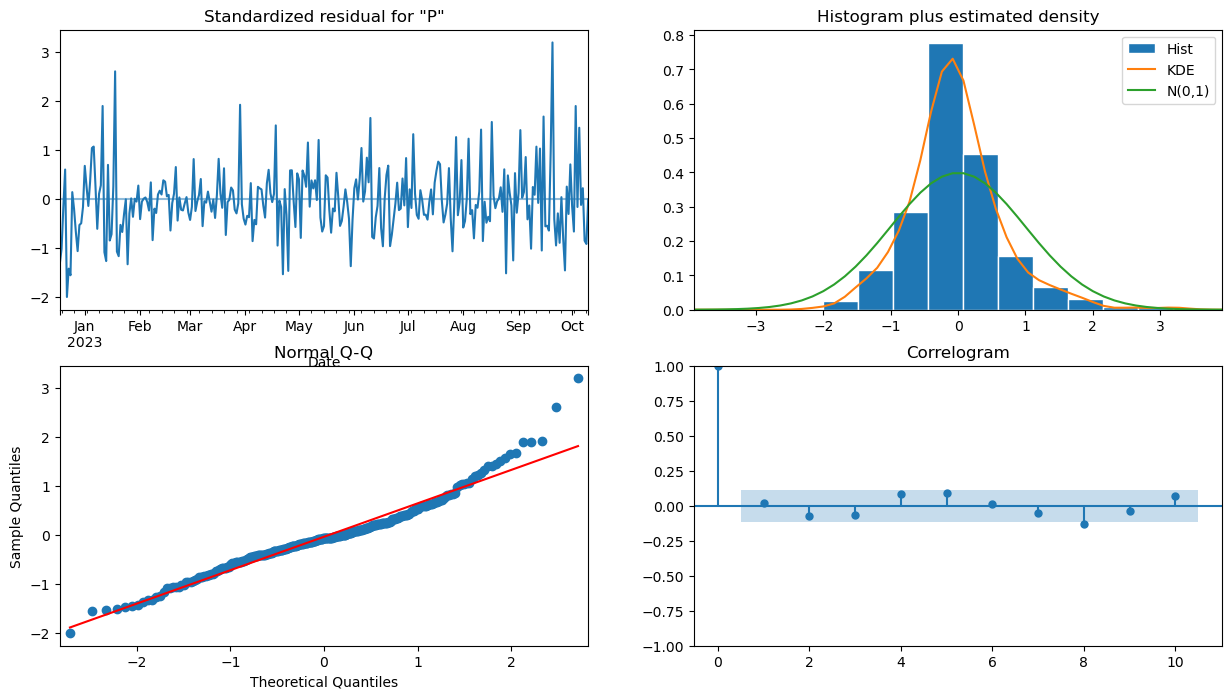

In [138]:
diag = results_auto_arima.plot_diagnostics()

### Naive

In [139]:
# Consideramos la muestra de evaluación y empezamos con pronósticos dentro de la muestra
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2023-10-11', '2023-10-12', '2023-10-13', '2023-10-14',
               '2023-10-15', '2023-10-16', '2023-10-17', '2023-10-18',
               '2023-10-19', '2023-10-20', '2023-10-21', '2023-10-22',
               '2023-10-23', '2023-10-24', '2023-10-25', '2023-10-26',
               '2023-10-27', '2023-10-28', '2023-10-29', '2023-10-30',
               '2023-10-31', '2023-11-01', '2023-11-02', '2023-11-03',
               '2023-11-04', '2023-11-05', '2023-11-06', '2023-11-07',
               '2023-11-08', '2023-11-09', '2023-11-10', '2023-11-11',
               '2023-11-12', '2023-11-13', '2023-11-14', '2023-11-15',
               '2023-11-16', '2023-11-17', '2023-11-18', '2023-11-19',
               '2023-11-20', '2023-11-21', '2023-11-22', '2023-11-23',
               '2023-11-24', '2023-11-25', '2023-11-26', '2023-11-27',
               '2023-11-28', '2023-11-29', '2023-11-30', '2023-12-01',
               '2023-12-02', '2023-12-03', '2023-12-04', '2023-12-05',
 

In [140]:
# Ajuste de las predicciones
forecaster = NaiveForecaster(strategy="last") 
forecaster.fit(y_train)
y_pred_naive = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Profit'>)

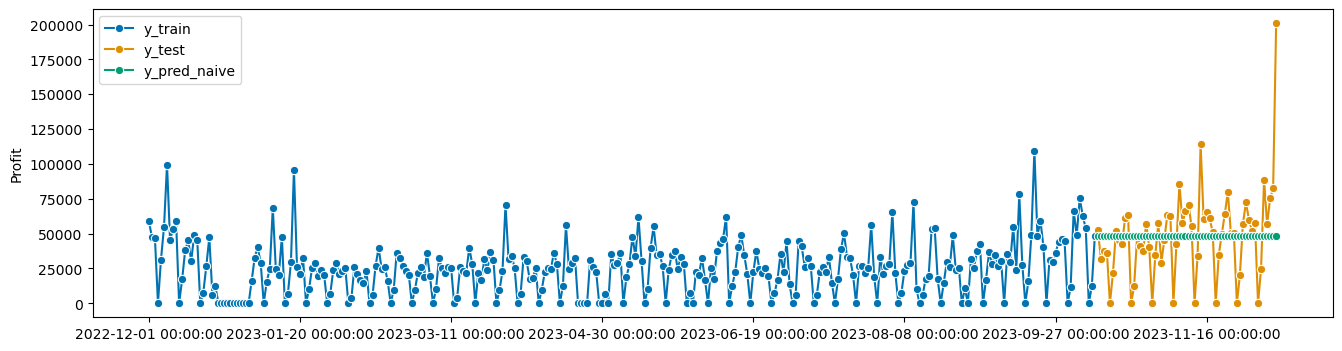

In [141]:
# Lo visualizamos
plot_series(y_train, y_test, y_pred_naive, labels=["y_train", "y_test", "y_pred_naive"])

In [142]:
# Introducimos una periodicidad semanal de 7
forecaster = NaiveForecaster(strategy="last", sp=7)
forecaster.fit(y_train)
y_pred_naive_imp = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Profit'>)

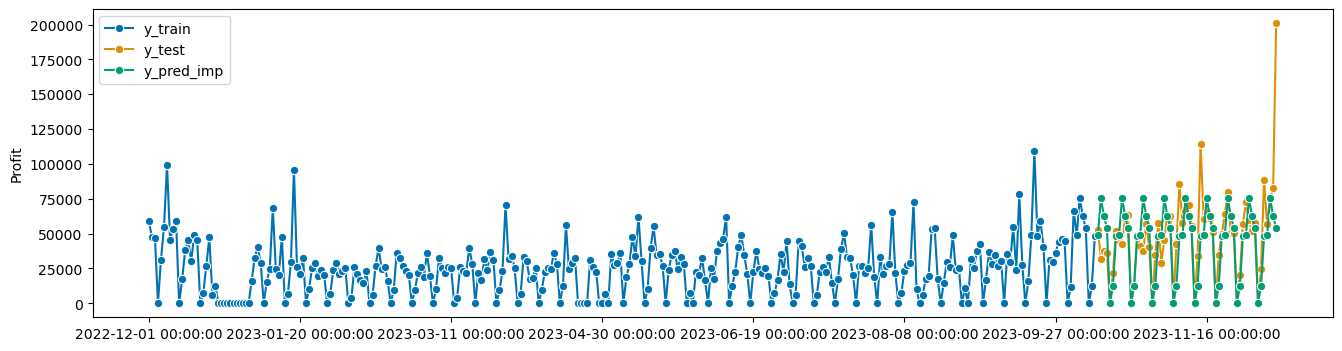

In [143]:
# Lo visualizamos
plot_series(y_train, y_test, y_pred_naive_imp, labels=["y_train", "y_test", "y_pred_imp"])

### XGBoost

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Profit'>)

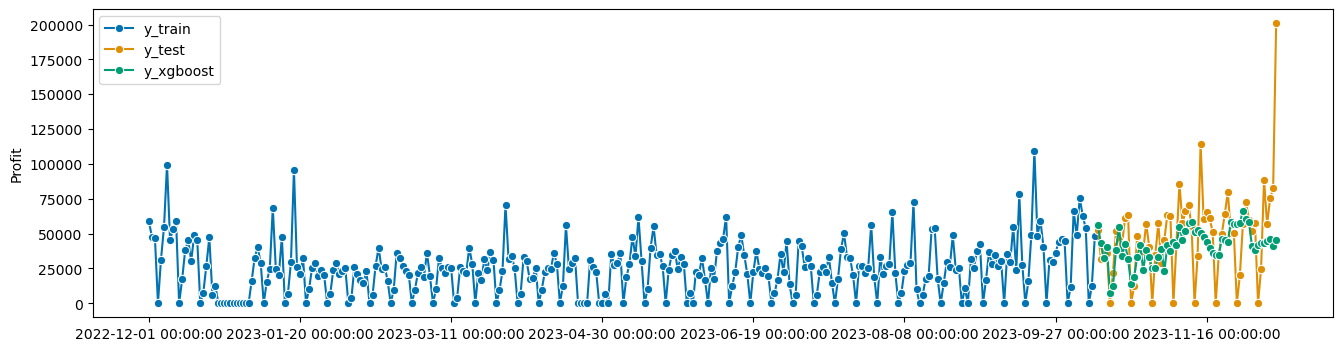

In [144]:
# Repetimos el proceso pero con XGBoost
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster_xgb = make_reduction(xgb_regressor, strategy="recursive")
forecaster_xgb.fit(y_train)
y_pred_xgboost = forecaster_xgb.predict(fh)
plot_series(y_train, y_test, y_pred_xgboost, labels=["y_train", "y_test","y_xgboost"])

In [145]:
# Evaluamos los 4 modelos probados
mae_autoarima = mean_absolute_error(y_test, forecast_auto_arima)
mae_naive = mean_absolute_error(y_test, y_pred_naive)
mae_naive_imp = mean_absolute_error(y_test, y_pred_naive_imp)
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)


maes = [mae_autoarima, mae_naive, mae_naive_imp,  mae_xgboost]
models = ['Autoarima','Naive', 'Naive Improved', 'XGBoost']

pd.DataFrame({'Model': models, 'MAE': maes}).sort_values(by='MAE', ascending=True)

,Model,MAE
0,Autoarima,13344.742587
2,Naive Improved,14530.996000
3,XGBoost,20941.445893
1,Naive,21770.315833


Según el MAE, vemos que el modelo más preciso ha sido el Autoarima.

## Preprocesamiento 2

Vamos a repetir el mismo proceso cambiando ciertos pasos, y probando únicamente con Autoarima y XGBoost.

In [146]:
# Hacemos una copia de df_profit para el segundo preprocesamiento
df_2 = df_profit.copy()

In [147]:
# Imputamos los valores nulos con el valor anterior conocido
df_2['Profit'] = df_2['Profit'].fillna(method='ffill')
# Comprobamos que no hay nulos en el df_2
assert df_baseline.isnull().sum().all() == 0, "Hay valores nulos en el df_baseline"

In [148]:
# Hacemos el test de Dickey Fuller
adf_test(df_2, 'Profit')

p-value of the Dickey-Fuller test: 0.9159587760


In [149]:
# El p-value es mayor, asi que aplicamos diferencia
df_2['diff_profit'] = df_2['Profit'] - df_2['Profit'].shift(1)
df_2.head()

,Profit,diff_profit
Date,,
2022-12-01,58776.79,NaN
2022-12-02,47629.42,-11147.37
2022-12-03,46898.63,-730.79
2022-12-04,46898.63,0.00
2022-12-05,31364.63,-15534.00


In [150]:
# Hacemos de nuevo el test de Dickey Fuller para comprobar la estacionariedad
adf_test(df_2, 'diff_profit')

p-value of the Dickey-Fuller test: 0.0000000329


La serie ahora es estacionaria en su parte general. Vamos a comprobar ahora la parte estacional.

In [151]:
df_2['seas_diff'] = df_2['Profit'] - df_2['Profit'].shift(7)
df_2

,Profit,diff_profit,seas_diff
Date,,,
2022-12-01,58776.79,NaN,NaN
2022-12-02,47629.42,-11147.37,NaN
2022-12-03,46898.63,-730.79,NaN
2022-12-04,46898.63,0.00,NaN
2022-12-05,31364.63,-15534.00,NaN
...,...,...,...
2023-12-05,88620.84,64143.37,31655.11
2023-12-06,56558.83,-32062.01,-15825.99
2023-12-07,75315.55,18756.72,15289.98


In [152]:
# Hacemos el test de Dickey Fuller sobre la diferencia estacional
adf_test(df_2, 'seas_diff')

p-value of the Dickey-Fuller test: 0.0000256155


In [153]:
# Aplicamos ahora el test de Mann-Kendall sobre la tendencia
check_trend(df_2['Profit'].dropna(), alpha=0.05)

Mann_Kendall_Test(trend='increasing', h=True, p=1.3322676295501878e-15, z=8.00227502311952, Tau=0.2771573167409786, s=19332.0, var_s=5835548.666666667, slope=67.75096209912537, intercept=16088.130568513116)

Rechazamos la hipótesis nula sobre la tendencia.

In [154]:
# Analizamos la heterocedasticidad
check_heteroscedastisticity(df_2['Profit'].dropna(), confidence = 0.05) 

White_Test(heteroscedastic=True, lm_statistic=17.42665221675017, lm_p_value=0.00016438059651454142)

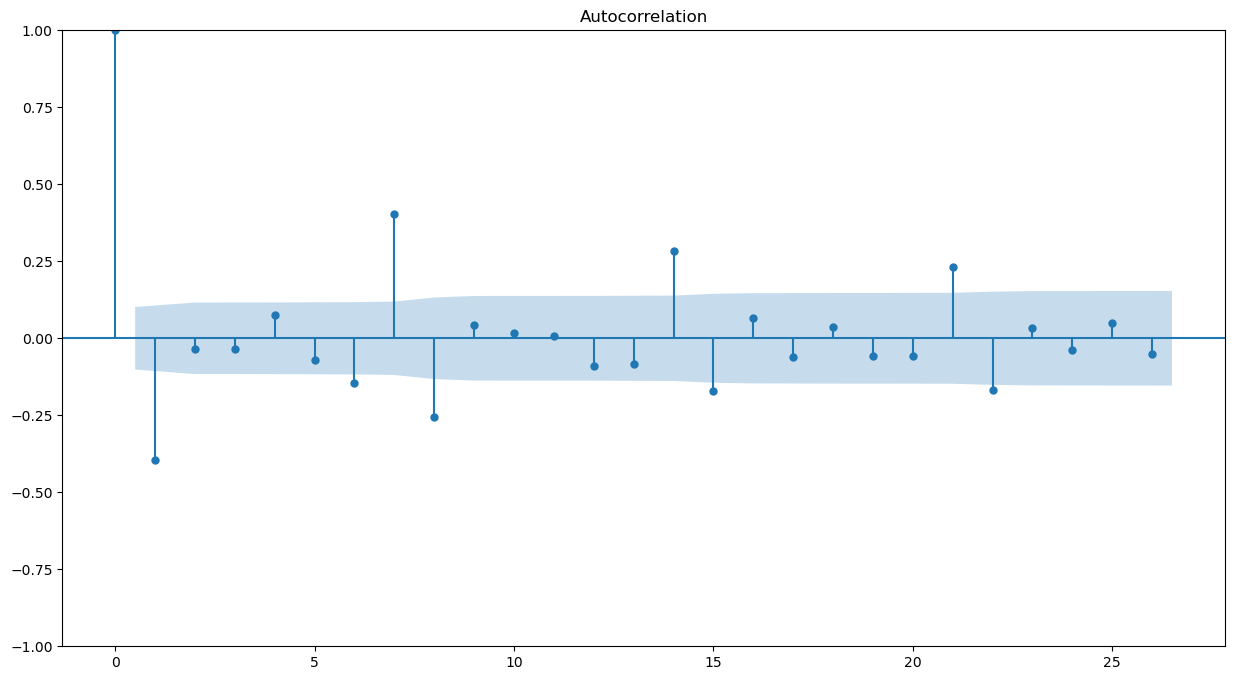

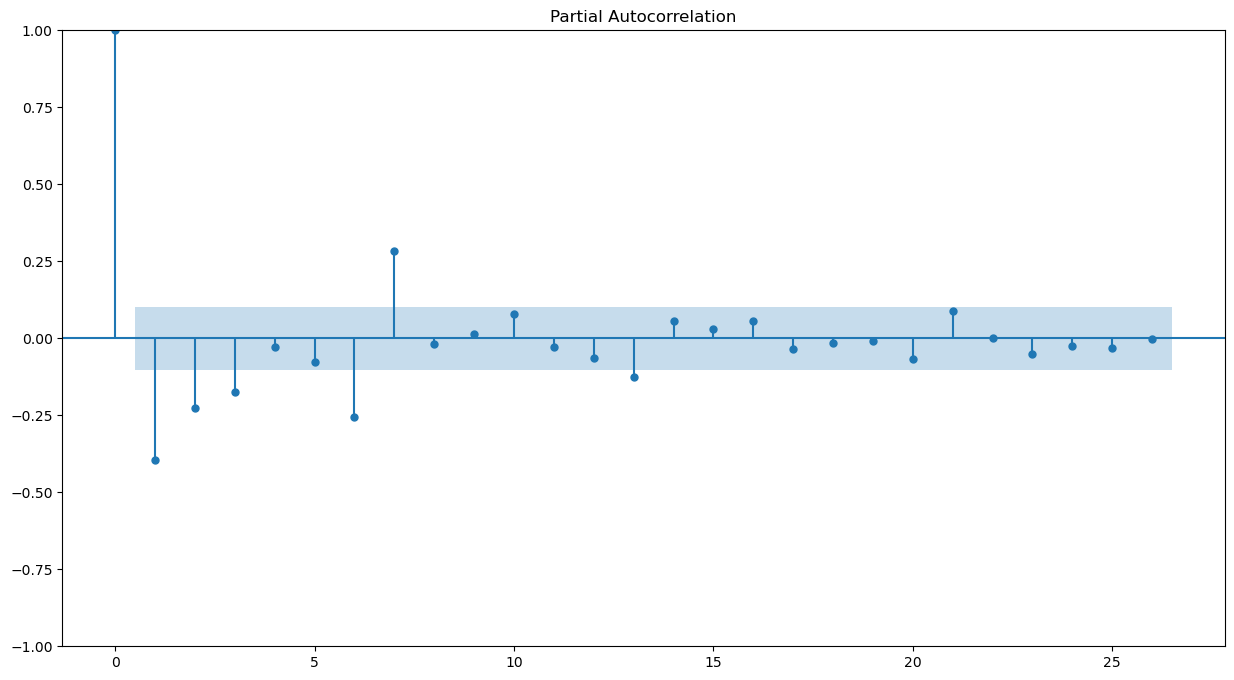

In [155]:
# Queremos ver ahora cómo se comporta la variable con la primera diferenciación aplicada y ver qué retardos meter al modelo
plot_acf_pacf(df_2, 'diff_profit')

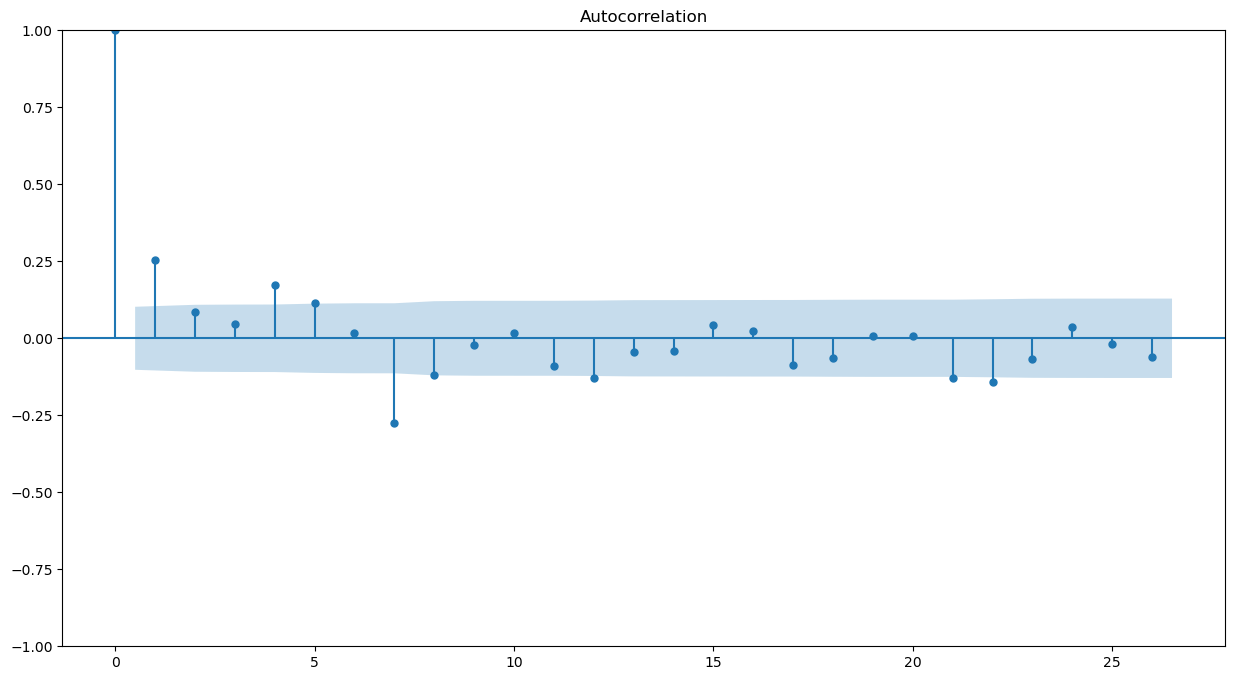

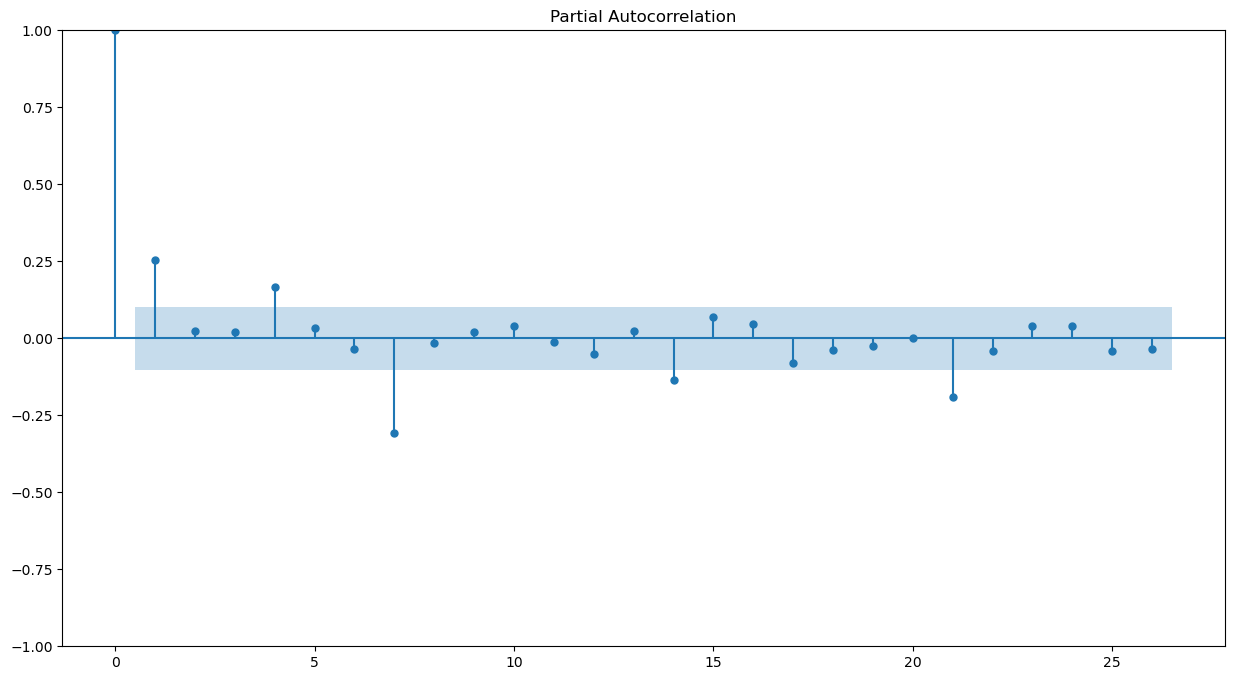

In [156]:
# Ahora hacemos un análisis general con el componente estacional
plot_acf_pacf(df_2, 'seas_diff')

In [157]:
# Partición en train y test
y_train, y_test = temporal_train_test_split(df_2['Profit'], test_size=60)

### Modelo Autoarima

In [158]:
# Ejecutamos Autoarima
auto_arima_pax = auto_arima(y_train, 
                       start_q=1,
                       max_p=7,
                       max_q=7,
                       m=7,
                       seasonal=True,
                       D=0,
                       max_d = 3,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
auto_arima_pax.summary()

Performing stepwise search to minimize aic


 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=6862.238, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=7049.593, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=6956.207, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=6896.924, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=7047.595, Time=0.02 sec
 ARIMA(2,1,1)(0,0,1)[7] intercept   : AIC=6892.712, Time=0.26 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=6886.342, Time=0.27 sec
 ARIMA(2,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=3.49 sec
 ARIMA(2,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=3.16 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=6914.949, Time=0.10 sec
 ARIMA(2,1,1)(0,0,2)[7] intercept   : AIC=6882.782, Time=2.42 sec
 ARIMA(2,1,1)(2,0,0)[7] intercept   : AIC=6885.816, Time=0.94 sec
 ARIMA(2,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=3.43 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=6860.987, Time=0.65 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=6890.792, Time=0.20 sec
 ARIMA(1,1,1)(1,0,0)[7] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  314
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -3419.798
Date:                             Sun, 04 Feb 2024   AIC                           6849.596
Time:                                     15:59:04   BIC                           6868.327
Sample:                                 12-01-2022   HQIC                          6857.082
                                      - 10-10-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7326      0.065    -11.292      0.000      -0.860      -0.605
ma.L2         -0.0921      0.075     -1.232      0.218      -0.239       0.054
ar.S.L7        0.9904      0.012     82.109      0.000       0.967       1.014
ma.S.L7       -0.9272      0.044    -21.259      0.000      -1.013      -0.842
sigma2      2.228e+08   9.46e-11   2.36e+18      0.000    2.23e+08    2.23e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               332.64
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             1.37
Prob(H) (two-sided):                  0.43   Kurtosis:                         7.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.68e+33. Standard errors may be unstable.
"""

In [159]:
# Ajuste del modelo
model_auto = SARIMAX(y_train,order=(0, 1, 2),
              seasonal_order=(1, 0, 1, 7),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_auto_arima = model_auto.fit()

In [160]:
# Predecimos
forecast_auto_arima = results_auto_arima.predict(start = len(y_train),
                           end=len(y_train)+59,
                           typ='levels').rename('forecast_auto_arima')

c:\Users\alici\anaconda3\envs\Nuclio\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



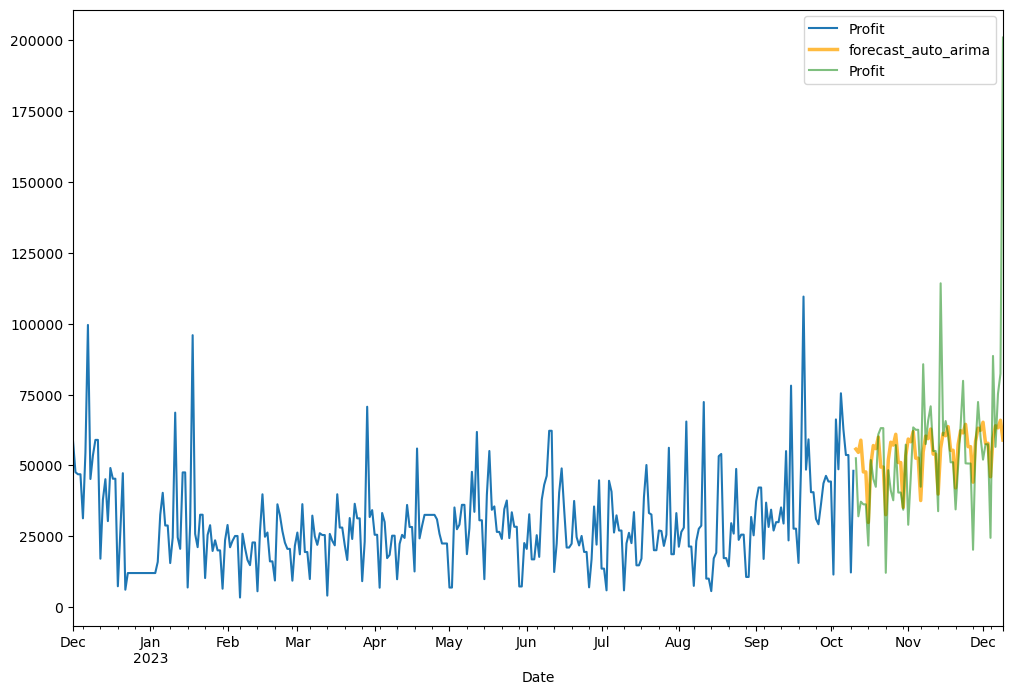

In [161]:
# Pintamos las predicciones
y_train.plot(figsize=(12,8),legend=True)
forecast_auto_arima.plot(legend=True, color='orange', alpha=0.75, linewidth=2.5)
y_test.plot(legend=True,color='green', alpha=0.5)

plt.show()

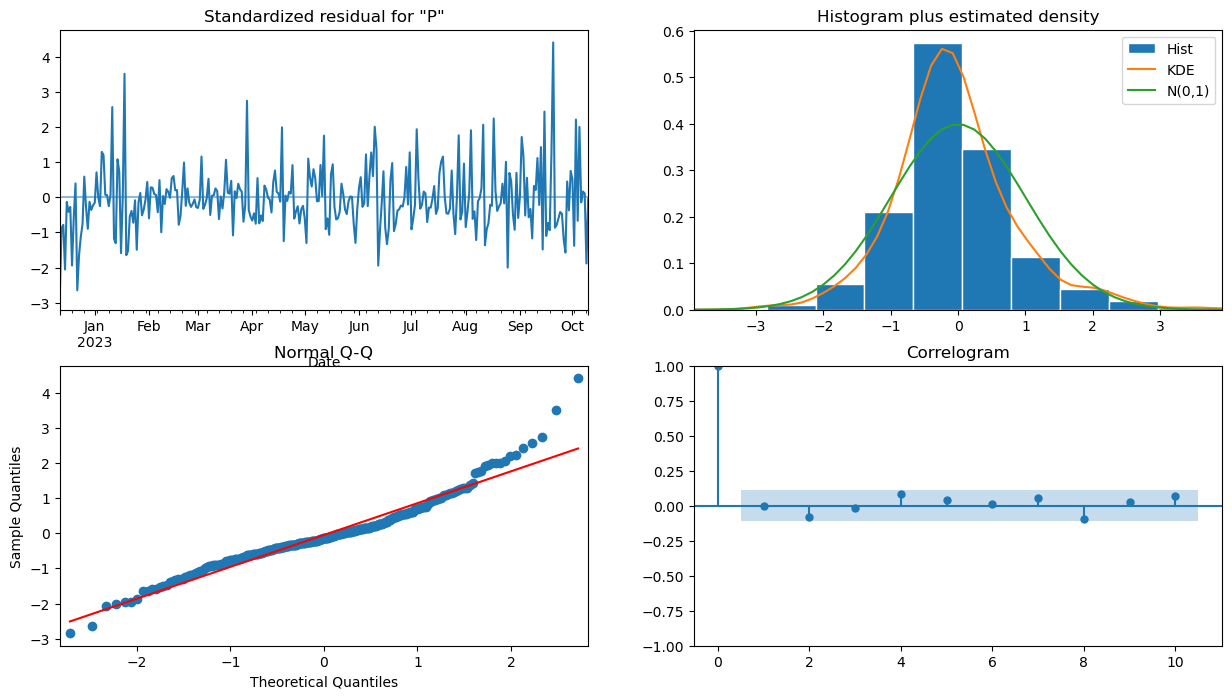

In [162]:
diag = results_auto_arima.plot_diagnostics()

### XGBoost

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Profit'>)

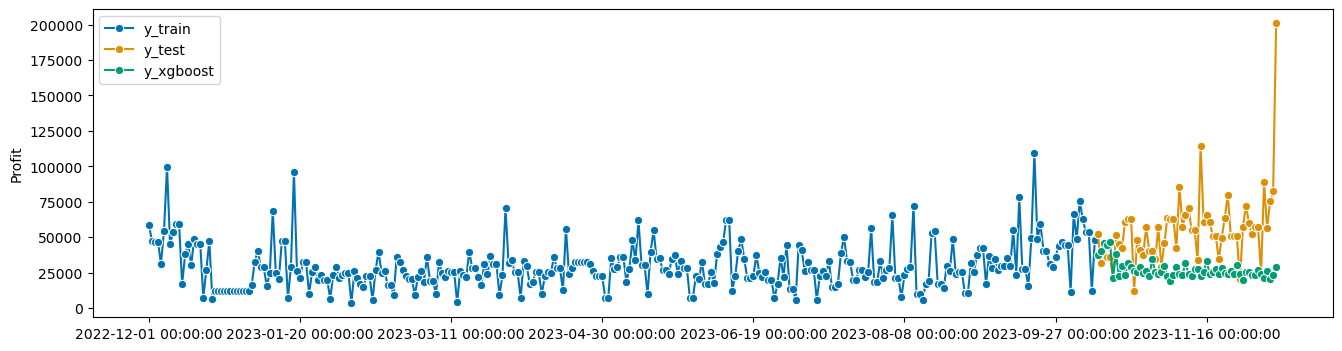

In [163]:
# Repetimos el proceso pero con XGBoost
xgb_regressor = XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster_xgb = make_reduction(xgb_regressor, strategy="recursive") # recursive, direct, mulitoutput
forecaster_xgb.fit(y_train)
y_pred_xgboost = forecaster_xgb.predict(fh)
plot_series(y_train, y_test, y_pred_xgboost, labels=["y_train", "y_test","y_xgboost"])

In [164]:
# Evaluamos los 2 modelos probados
mae_autoarima = mean_absolute_error(y_test, forecast_auto_arima)
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
maes = [mae_autoarima,mae_xgboost]
models = ['Autoarima','XGBoost']

pd.DataFrame({'Model': models, 'MAE': maes}).sort_values(by='MAE', ascending=True)

,Model,MAE
0,Autoarima,12751.117449
1,XGBoost,30032.454668


Parece haber bajado el MAE en ambos modelos, siendo aún así el Autoarima el mejor como en el preprocesamiento 1.

### Preprocesamiento 3

En el preprocesamiento 3, vamos a intentar mejorar XGBoost añadiendo transformadores y aplicando CV.

In [165]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
validation_size = len(y_test) 
cv = SingleWindowSplitter(window_length=len(df_2)-validation_size,  
                          fh=validation_size) 

# Ajustamos el regresor y los transformadores que necesitamos
regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize_week", Deseasonalizer(model="additive", sp=7)), # Desestacionalizamos cada 7 días
        ('LogTransformer', BoxCoxTransformer(method= 'guerrero', sp=7)), # Corregimos heterocedasticidad
        ('HampelFilter', HampelFilter(window_length=30)), # Suavizamos outliers
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=3))), # Eliminamos tendencia
        ("forecast", make_reduction(regressor, window_length=30, scitype='tabular-regressor')), # Ajustamos el modelo considerando los últimos 30 días 
        
    ]
)

model= make_reduction(regressor, window_length=30,  scitype='tabular-regressor')

param_grid = {
    'estimator__max_depth': [3, 5, 6, 10, 15, 20,30],
    'estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'estimator__n_estimators': [100,200,300, 500, 1000]
}
gscv = ForecastingRandomizedSearchCV(model, cv=cv, param_distributions=param_grid, n_iter=100, random_state=42,error_score='raise',n_jobs=-1)

gscv.fit(y_train)
y_pred_cv_xgb = gscv.predict(fh)

c:\Users\alici\anaconda3\envs\Nuclio\Lib\site-packages\sktime\forecasting\model_selection\_tune.py:201: UserWarning:

in ForecastingRandomizedSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.27.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Profit'>)

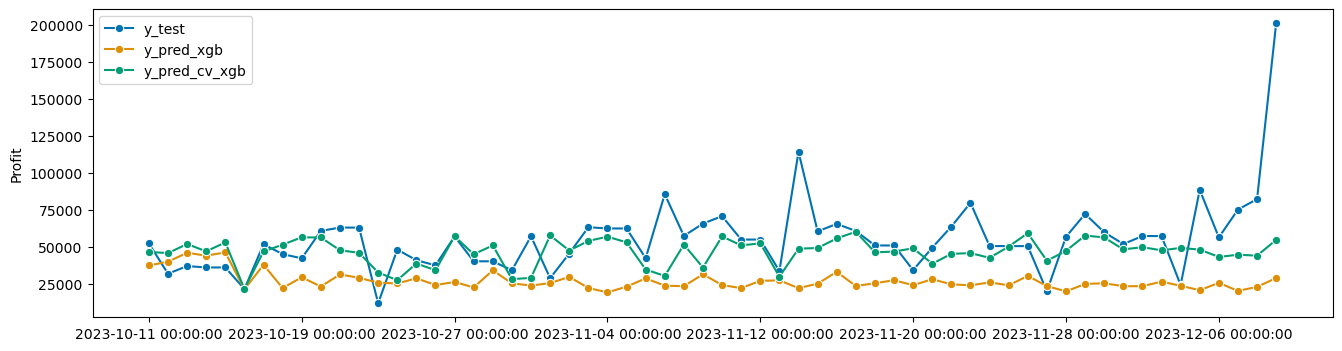

In [166]:
# Visualizamos predicciones en la muestra de evaluación
plot_series(y_test, y_pred_xgboost, y_pred_cv_xgb, labels=["y_test", "y_pred_xgb", "y_pred_cv_xgb"])

In [167]:
mae_xgboost_cv = mean_absolute_error(y_test, y_pred_cv_xgb)


mae = [mae_xgboost_cv]
model = ['XGBoost CV']

pd.DataFrame({'Model': model, 'MAE': mae}).sort_values(by='MAE', ascending=True)

,Model,MAE
0,XGBoost CV,15836.604031


Notamos cierta mejora en el XGBoost después de haber aplicado los transformadores y la CV, siendo de nuevo menos preciso que el Autoarima.